In [17]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import gpytorch
import os
import GPy
from bayes_opt import BayesianOptimization
import torch
import GPyOpt
# from GPyOpt.methods import BayesianOptimization
import numpy as np
# import plotly
import matplotlib.mlab as mlab
import sklearn as sk
from matplotlib import gridspec

In [2]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel() + gpytorch.kernels.LinearKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [3]:
data = pd.read_excel("DOE_Complete.xlsx", sheet_name=1)
print(data.info())
data['thc'] = data['thc'].str.rstrip('%').astype("float")/100
data['cbd'] = data['cbd'].str.rstrip('%').astype("float")/100
data['abn_cbd'] = data['abn_cbd'].str.rstrip('%').astype("float")/100
data['bis'] = data['bis'].str.rstrip('%').astype("float")/100
# data["fit"] = 1 - (data.thc * 100 + (1 - data.cbd) + data.abn_cbd + data.bis
data["fit"] = data["cbd"] - data.thc*10 - data.abn_cbd*2 - data.bis
print(data.head())
data.describe()
    


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ol       23 non-null     float64
 1   al       23 non-null     float64
 2   bf       23 non-null     float64
 3   temp     23 non-null     float64
 4   thc      23 non-null     object 
 5   cbd      23 non-null     object 
 6   abn_cbd  23 non-null     object 
 7   bis      23 non-null     object 
dtypes: float64(4), object(4)
memory usage: 1.6+ KB
None
      ol     al    bf  temp   thc   cbd  abn_cbd   bis   fit
0  2.050  1.000  0.11  75.0  0.07  0.38     0.23  0.02 -0.80
1  2.050  1.000  0.11  75.0  0.09  0.38     0.23  0.02 -1.00
2  2.050  1.000  0.11  75.0  0.07  0.39     0.27  0.03 -0.88
3  3.000  1.000  0.11  75.0  0.07  0.40     0.24  0.04 -0.82
4  2.525  1.433  0.11  75.0  0.00  0.44     0.33  0.03 -0.25


,ol,al,bf,temp,thc,cbd,abn_cbd,bis,fit
count,23.000000,23.000000,23.00000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,2.050000,1.000000,0.11000,75.000000,0.105217,0.302174,0.239565,0.027826,-1.256957
std,0.452895,0.238359,0.04288,7.154864,0.134227,0.098302,0.114712,0.032746,1.182095
min,1.100000,0.567000,0.03656,63.135000,0.000000,0.130000,0.060000,0.000000,-4.330000
25%,1.575000,0.855500,0.09164,75.000000,0.000000,0.230000,0.135000,0.010000,-1.735000
50%,2.050000,1.000000,0.11000,75.000000,0.070000,0.300000,0.240000,0.020000,-0.800000
75%,2.525000,1.144500,0.12836,75.000000,0.160000,0.385000,0.325000,0.035000,-0.550000
max,3.000000,1.433000,0.18344,86.865000,0.440000,0.440000,0.440000,0.150000,-0.250000


In [4]:
# corr = data.corr()
# sb.heatmap(corr)
# plt.show()
x = data.iloc[:,:4].copy().values
print(type(x), x.shape, x[0], type(x[0]), x[0].shape)
y = data["fit"].copy().values.reshape(-1,1)
xt = torch.tensor(x)
yt = torch.tensor(y)
# initialize likelihood and model
# print(y, y.shape)



<class 'numpy.ndarray'> (23, 4) [ 2.05  1.    0.11 75.  ] <class 'numpy.ndarray'> (4,)


In [5]:
data2 = pd.read_excel("DOE_Complete.xlsx", sheet_name=2)
x=data2.values

In [6]:
def bbox(ol, al, bf, temp):
    data = np.array([ol,al,bf,temp]).reshape(-1, 4)
    # print(data)
    predict = gpr.predict(data)
    # print(predict, type(predict), predict.shape)

    return predict[0][0]

In [7]:
from sklearn import linear_model
reg = linear_model.Ridge(alpha=.01)
reg.fit(x,y)
print(reg.coef_, reg.score(x,y))


[[-0.62075848  0.96342968 -1.53367868 -0.09650866]] 0.5994390106870718


In [8]:
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

In [9]:
kern = RBF([1,1,1,1]) + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kern, random_state=0).fit(x, y)

In [10]:
gpr.score(x,y)

0.8575264605869649

In [11]:
data2.describe()

,ol,al,bf,temp
count,23.000000,23.000000,2.300000e+01,2.300000e+01
mean,0.000000,0.000000,-1.448117e-17,-9.654113e-18
std,0.476731,0.476717,4.764414e-01,4.769909e-01
min,-1.000000,-0.866000,-8.160000e-01,-7.910000e-01
25%,-0.500000,-0.289000,-2.040000e-01,0.000000e+00
50%,0.000000,0.000000,0.000000e+00,0.000000e+00
75%,0.500000,0.289000,2.040000e-01,0.000000e+00
max,1.000000,0.866000,8.160000e-01,7.910000e-01


In [12]:
pbounds = {'ol': (-1, 1), 'al': (-.86, .86), "bf": (-.816, .816), "temp": (-.8, .8)}
# print(bbox(0.917022004702574, 0.14084542908190212, 1.1002173121529553, 70.25598174316416))
optimizer = BayesianOptimization(
    f=bbox,
    pbounds=pbounds,
        verbose=2,  # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
        random_state=1
    )
optimizer.maximize()
print(optimizer.max)

|   iter    |  target   |    al     |    bf     |    ol     |   temp    |
-------------------------------------------------------------------------
|  1        | -0.8642   | -0.1427   |  0.3596   | -0.9998   | -0.3163   |
|  2        | -0.5134   | -0.6076   | -0.6653   | -0.6275   | -0.2471   |
|  3        | -1.169    | -0.1776   |  0.06335  | -0.1616   |  0.2964   |
|  4        | -1.445    | -0.5083   |  0.6171   | -0.9452   |  0.2727   |
|  5        | -0.6692   | -0.1422   |  0.09578  | -0.7192   | -0.483    |
|  6        | -0.3337   | -0.1636   | -0.8082   | -1.0      | -0.8      |
|  7        | -0.5095   |  0.86     | -0.816    | -0.3211   | -0.8      |
|  8        | -0.8071   | -0.86     | -0.816    |  0.856    | -0.8      |
|  9        | -0.4455   |  0.86     | -0.816    | -1.0      |  0.02419  |
|  10       | -0.2223   |  0.86     | -0.02808  | -1.0      | -0.8      |
|  11       | -2.219    |  0.86     |  0.816    |  1.0      | -0.8      |
|  12       | -0.4455   |  0.86     | 

In [13]:
# GPy.plotting.change_plotting_library('plotly')

GP_regression.,value,constraints,priors
sum.rbf.variance,1.0,+ve,
sum.rbf.lengthscale,1.0,+ve,
sum.white.variance,1.0,+ve,
sum.linear.variances,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


GP_regression.,value,constraints,priors
sum.rbf.variance,3.2537215510815782,+ve,
sum.rbf.lengthscale,0.9342009891748048,+ve,
sum.white.variance,0.005138821140645416,+ve,
sum.linear.variances,8.92693073518568e-06,+ve,
Gaussian_noise.variance,0.005138821140645416,+ve,


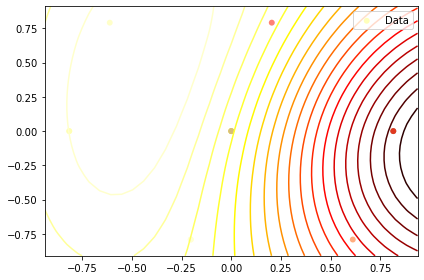

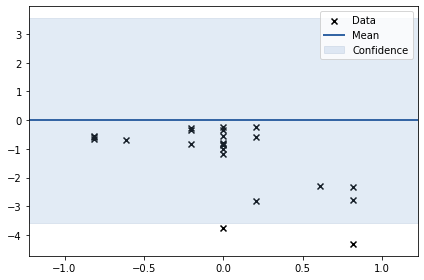

In [14]:
kernel = GPy.kern.RBF(input_dim=4, variance=1., lengthscale=1.) + GPy.kern.White(4) + GPy.kern.Linear(input_dim=4)
global m
m = GPy.models.GPRegression(x, y, kernel)
display(m)
# fig = m.plot(fixed_inputs=[(0, 1.1), (1, 0.57)])
# GPy.plotting.show(fig, filename='basic_gp_regression_notebook')
# plt.show()
m.optimize(messages=False)
display(m)
# m.optimize_restarts(num_restarts=100)
# GPy.plotting.show(fig, filename='basic_gp_regression_notebook_optimized')
# fig = m.plot(plot_density=True, fixed_inputs=[(0, 1.1), (1, 0.57), (3, 75)])
fig = m.plot(plot_density=True, fixed_inputs=[(0, 1.1), (1, 0.57)])
plt.show()
fig = m.plot(fixed_inputs=[(0, 1.1), (1, 0.57), (3, 75)])
plt.show()
# GPy.plotting.show(fig, filename='basic_gp_regression_density_notebook_optimized')

# print(m.predict(Xnew=np.array([[0.917022004702574, 0.14084542908190212, 1.1002173121529553, 70.25598174316416]])))
# print(dir(m))

In [15]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(xt, yt, likelihood)

In [16]:
# # this is for running the notebook in our testing framework
# import os
# smoke_test = ('CI' in os.environ)
# training_iter = 2 if smoke_test else 50


# # Find optimal model hyperparameters
# model.train()
# likelihood.train()

# # Use the adam optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# # "Loss" for GPs - the marginal log likelihood
# mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# for i in range(training_iter):
#     # Zero gradients from previous iteration
#     optimizer.zero_grad()
#     # Output from model
#     output = model(xt)
#     # Calc loss and backprop gradients
#     loss = -mll(output, yt)
#     loss.backward()
#     print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
#         i + 1, training_iter, loss.item(),
#         model.covar_module.base_kernel.lengthscale.item(),
#         model.likelihood.noise.item()
#     ))
#     optimizer.step()



In [25]:
def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)

    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

def plot_gp(optimizer, x, y):
    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
    fig.suptitle(
        'Gaussian Process and Utility Function After {} Steps'.format(steps),
        fontdict={'size':30}
    )
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    x_obs = np.array([[res["params"]["ol"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(x_obs.flatten(), y_obs, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((-2, 10))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    utility_function = UtilityFunction(kind="ucb", kappa=5, xi=0)
    utility = utility_function.utility(x, optimizer._gp, 0)
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((-2, 10))
    acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

ValueError: X has 4 features, but GaussianProcessRegressor is expecting 1 features as input.

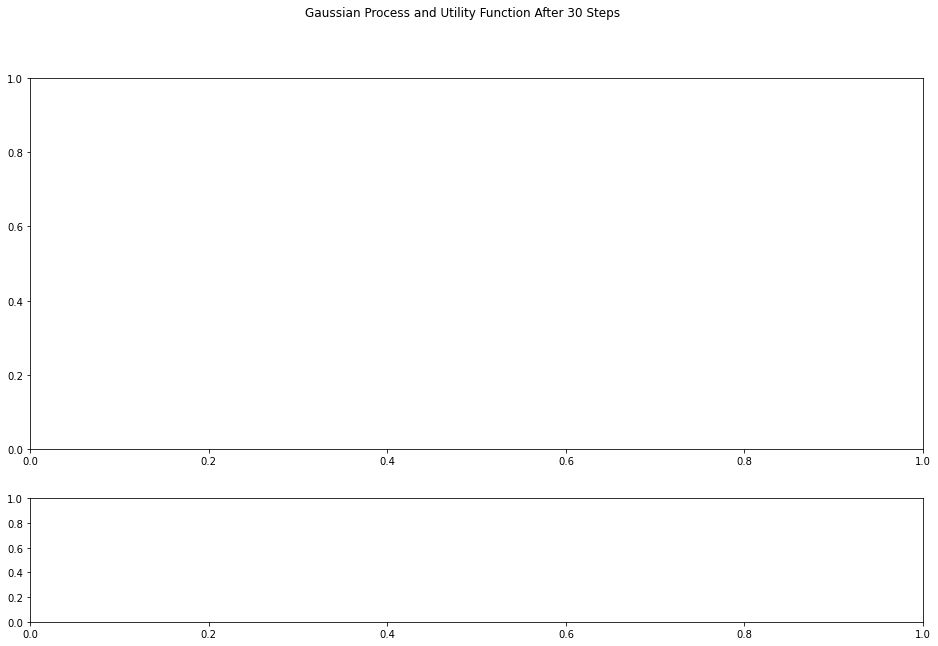

In [26]:
plot_gp(optimizer, x, y)

In [27]:
data2.head()
data2["util"]

,ol,al,bf,temp
0,0.0,0.000,0.0,0.0
1,0.0,0.000,0.0,0.0
2,0.0,0.000,0.0,0.0
3,1.0,0.000,0.0,0.0
4,0.5,0.866,0.0,0.0


In [ ]:

for i in data2.ol.unique():
    sb.scatterplot(data=data2.loc[data2.ol==i], x = "al", y="temp")